In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path

path = Path('data')
train_labels = pd.read_csv(path / 'train_labels.csv')
train_labels

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...
...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...


# Image encoder

In [72]:
import torch
import timm

class Encoder(torch.nn.Module):
    def __init__(self, backbone='resnet18', pretrained=False, in_channels=1):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained, features_only=True, in_chans=in_channels)
        #self.head = torch.nn.Sequential(
        #    torch.nn.AdaptiveAvgPool2d(output_size=(1,1)),
        #    torch.nn.Flatten()
        #)
    def forward(self, x):
        features = self.backbone(x)
        #return self.head(features[-1])        
        #return features[-1]        
        bs, c, h, w = features[-1].size()
        return features[-1].view(bs, c, -1)

In [73]:
encoder = Encoder()
out = encoder(torch.randn(32, 1, 128, 128))
out.shape

torch.Size([32, 512, 16])

# Text generator

In [74]:
class Decoder(torch.nn.Module):
    def __init__(self, len_vocab, d_model=16, nhead=1, num_layers=1):
        super().__init__()
        self.len_vocab = len_vocab
        #self.embedding = torch.nn.Embedding(len(VOCAB), 100)
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = torch.nn.Linear(d_model, len_vocab)
        
    def forward(self, x):
        # batch, len 
        #e = self.embedding(x)
        # batch, len, features
        o = self.transformer(x)
        B, L, F = o.size()
        # batch x len, features
        o = self.head(o.contiguous().view(-1, F))
        return o.contiguous().view(B, L, self.len_vocab)

In [75]:
len_vocab = 10
decoder = Decoder(len_vocab)
out = decoder(torch.rand((32, 512, 16)))
out.shape

torch.Size([32, 512, 10])

# Vocab

In [77]:
InChIs = train_labels.InChI.map(lambda x: x.split('/')[1])
#InChIs = train_labels.InChI.map(lambda x: ('/').join(x.split('/')[1:4]))
InChIs

0                C13H20OS
1                C21H30O4
2              C24H23N5O4
3             C17H24N2O4S
4             C10H19N3O2S
                ...      
2424181      C10H12F2N2O3
2424182     C19H20F2N4O3S
2424183    C22H26Cl2N2O4S
2424184       C17H26N2O6S
2424185      C10H18N2O9P2
Name: InChI, Length: 2424186, dtype: object

In [78]:
InChIs.map(len).min(), InChIs.map(len).max()

(4, 20)

In [9]:
from src.vocab import compute_vocab

special = ['PAD', 'SOS', 'EOS']
vocab = special + sorted(list({s for InChI in InChIs for s in InChI}))
vocab, len(vocab)

(['PAD',
  'SOS',
  'EOS',
  '(',
  ')',
  '+',
  ',',
  '-',
  '/',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'B',
  'C',
  'F',
  'H',
  'I',
  'N',
  'O',
  'P',
  'S',
  'b',
  'c',
  'h',
  'i',
  'l',
  'r',
  't'],
 35)

In [10]:
def t2ix(t, vocab):
    return vocab.index(t)

def encode(InChI, vocab):
    tokens = [w for w in InChI]
    ixs = [t2ix(token, vocab) for token in tokens]
    return ixs

def decode(encoded, vocab):
    return ('').join([vocab[ix] for ix in encoded])

In [11]:
InChI = InChIs[0]
InChI

'C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3'

In [12]:
encoded = encode(InChI, vocab)
encoded

[20,
 10,
 12,
 22,
 11,
 9,
 25,
 27,
 8,
 29,
 10,
 7,
 18,
 3,
 11,
 4,
 17,
 7,
 10,
 14,
 7,
 10,
 12,
 7,
 15,
 7,
 14,
 7,
 10,
 9,
 3,
 12,
 4,
 16,
 7,
 10,
 11,
 3,
 10,
 12,
 4,
 10,
 10,
 3,
 13,
 4,
 10,
 13,
 8,
 30,
 14,
 7,
 16,
 6,
 18,
 6,
 10,
 10,
 6,
 10,
 13,
 22,
 6,
 17,
 22,
 11,
 6,
 10,
 7,
 13,
 22,
 12]

In [13]:
decoded = decode(encoded, vocab)
decoded

'C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3'

In [14]:
assert InChI == decoded

# Datamodule

In [69]:
from src.utils import parse_config_file

config_file = 'debug.yml'
config = parse_config_file(config_file)
config

{'lr': 0.01,
 'optimizer': 'Adam',
 'batch_size': 1,
 'num_workers': 0,
 'pin_memory': True,
 'subset': 0.001,
 'model': 'Baseline',
 'backbone': 'resnet18',
 'pretrained': False,
 'rnn': 'GRU',
 'max_len': 512,
 'train_trans': {'Resize': {'width': 128, 'height': 128}},
 'val_trans': {'Resize': {'width': 128, 'height': 128}},
 'gpus': 1,
 'precision': 16,
 'max_epochs': 50,
 'train_batches': 1,
 'shuffle_train': False,
 'val_batches': 1,
 'val_with_train': True,
 'log': False}

In [48]:
from src.dm import DataModule

dm = DataModule(**config)
dm.setup()

Training samples:  2181
Validation samples:  243


In [49]:
images, inchis = next(iter(dm.train_dataloader()))
images.shape, inchis.shape

(torch.Size([1, 1, 128, 128]), torch.Size([1, 512]))

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


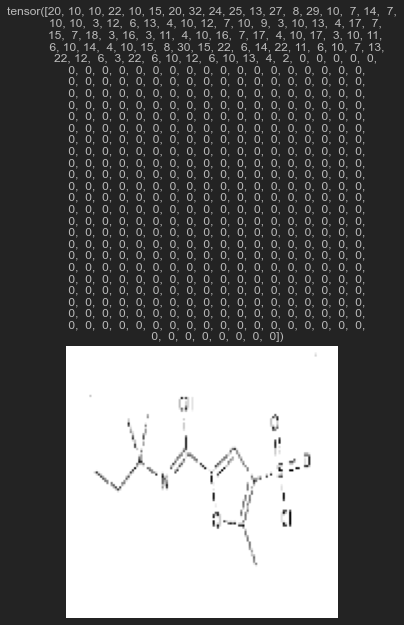

In [50]:
import matplotlib.pyplot as plt
from skimage import io
import random

rows, columns = 1, 1
fig = plt.figure(figsize=(5,5))
ix = 0
for r in range(rows):
    for c in range(columns):
        image = images[ix]
        ax = plt.subplot(rows, columns, ix + 1)
        ax.imshow(image.squeeze(0), cmap="gray")
        ax.axis('off')
        ax.set_title(inchis[ix], size=12)
        ix += 1
plt.tight_layout()
plt.show()

In [51]:
decode(inchis[0], vocab).split('EOS')[0]

'C11H16ClNO4S/c1-5-11(3,4)13-10(14)8-6-9(7(2)17-8)18(12,15)16/h6H,5H2,1-4H3,(H,13,14)'

# Fit one sample

In [70]:
import pytorch_lightning as pl

dm = DataModule(**config)

trainer = pl.Trainer(
    gpus=config['gpus'],
    precision=config['precision'],
    max_epochs=1,
    limit_train_batches=config['train_batches'],
    limit_val_batches=config['val_batches']
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [71]:
from src import models

model = getattr(models, config['model'])(config)

trainer.fit(model, dm)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 11.2 M
1 | decoder | Decoder | 69.3 K
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


Training samples:  2181
Validation samples:  243


torch.Size([1, 512, 35])


1

In [66]:
preds = model.predict(images)
preds

['411H16CH8,43/11-(-11(3,4)13-1((14)8-6-1(/(2)1)-8)18(12,1()16//6H,(H2,1-4H3,(H,13,14))PADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADP

In [67]:
gt = decode(inchis[0], vocab).split('EOS')[0]
gt

'C11H16ClNO4S/c1-5-11(3,4)13-10(14)8-6-9(7(2)17-8)18(12,15)16/h6H,5H2,1-4H3,(H,13,14)'

In [68]:
from Levenshtein import distance

distance(preds[0], gt)

1296

# Fit one batch

In [ ]:
config_file = 'debug.yml'
config = parse_config_file(config_file)
config

In [ ]:
dm = DataModule(**config)

trainer = pl.Trainer(
    gpus=config['gpus'],
    precision=config['precision'],
    max_epochs=500,
    limit_train_batches=config['train_batches'],
    limit_val_batches=config['val_batches']
)

In [ ]:
model = getattr(models, config['model'])(config)

trainer.fit(model, dm)

In [ ]:
images, inchis = next(iter(dm.train_dataloader()))
images.shape, inchis.shape

In [ ]:
preds = model.predict(images)
preds

In [ ]:
gts = []
for inchi in inchis:
    gts.append(decode(inchi, vocab).split('EOS')[0])
gts

In [ ]:
metrics = []
for pred, gt in zip(preds, gts):
    metrics.append(distance(pred, gt))
metrics